In [ ]:
"""
Please download all necessary packages below in a new conda environment:
conda install numpy pandas scikit-learn
conda install matplotlib jupyterlab
conda install pytorch torchvision torchaudio -c pytorch  # For neural network
# Or use pip: pip install torch
"""

import pandas as pd
import numpy as np



# ============================================================
# 0. Load local CSV: 'train.csv'
#    Assumes last column is 'critical_temp' or a column with that name.
# ============================================================
data_path = "train.csv"  # <- change to your actual path if needed
df = pd.read_csv(data_path)

# If the target column is not named 'critical_temp', adjust here:
if "critical_temp" in df.columns:
    target_col = "critical_temp"
else:
    # assume last column is the target
    target_col = df.columns[-1]
    print(f"WARNING: 'critical_temp' not found; using last column '{target_col}' as target.")

X = df.drop(columns=[target_col])
y = df[target_col]

print("=== Full dataset loaded from train.csv ===")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 5 feature names:", list(X.columns[:5]))
print()

=== Full dataset loaded from train.csv ===
X shape: (21263, 81)
y shape: (21263,)
First 5 feature names: ['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass']



In [2]:
# Step 1: temp (85%) + verification (15%)
from sklearn.model_selection import train_test_split


X_temp, X_verif, y_temp, y_verif = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42
)

# Step 2: train + val from temp
val_fraction_within_temp = 0.15 / 0.85  # ≈ 0.17647 => overall 15% for val

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=val_fraction_within_temp,
    random_state=42
)

n_total = X.shape[0]
print("=== Split summary (70/15/15) ===")
print(f"Total samples:       {n_total}")
print(f"Train size:          {X_train.shape[0]}  ({X_train.shape[0]/n_total:.3f})")
print(f"Validation size:     {X_val.shape[0]}    ({X_val.shape[0]/n_total:.3f})")
print(f"Verification size:   {X_verif.shape[0]}  ({X_verif.shape[0]/n_total:.3f})")
print()


feat_names = X_train.columns  # all feature names

=== Split summary (70/15/15) ===
Total samples:       21263
Train size:          14883  (0.700)
Validation size:     3190    (0.150)
Verification size:   3190  (0.150)



In [3]:
# ============================================================
# Helper: map feature name -> human-readable English description
# ============================================================
def describe_feature(name: str) -> str:
    # Special case
    if name == "number_of_elements":
        return "Number of distinct chemical elements present in the compound."

    # Map property token to a human-readable phrase
    prop_map = {
        "atomic_mass": "atomic mass of constituent elements",
        "fie": "first ionization energy of constituent elements",
        "atomic_radius": "atomic radius of constituent elements",
        "Density": "mass density of constituent elements",
        "ElectronAffinity": "electron affinity of constituent elements",
        "FusionHeat": "heat of fusion (fusion enthalpy) of constituent elements",
        "ThermalConductivity": "thermal conductivity of constituent elements",
        "Valence": "valence electron count of constituent elements",
    }

    # Identify prefix and property name
    prefix = None
    prop_token = None
    for pre in [
        "wtd_mean_", "mean_",
        "wtd_gmean_", "gmean_",
        "wtd_entropy_", "entropy_",
        "wtd_range_", "range_",
        "wtd_std_", "std_",
    ]:
        if name.startswith(pre):
            prefix = pre
            prop_token = name[len(pre):]
            break

    # Fallback: generic description
    if prefix is None or prop_token is None:
        return f"Descriptor derived from elemental property '{name}', computed over the compound's composition."

    prop_phrase = prop_map.get(
        prop_token,
        f"property '{prop_token}' of constituent elements"
    )

    # Construct description according to prefix
    if prefix == "mean_":
        return f"Unweighted arithmetic mean of the {prop_phrase} in the compound."
    if prefix == "wtd_mean_":
        return f"Atomic-fraction-weighted arithmetic mean of the {prop_phrase} in the compound."
    if prefix == "gmean_":
        return f"Unweighted geometric mean of the {prop_phrase} in the compound."
    if prefix == "wtd_gmean_":
        return f"Atomic-fraction-weighted geometric mean of the {prop_phrase} in the compound."
    if prefix == "entropy_":
        return f"Entropy-like measure of how heterogeneous the {prop_phrase} are across different elements in the compound (higher = more diverse)."
    if prefix == "wtd_entropy_":
        return f"Atomic-fraction-weighted entropy-like measure of how heterogeneous the {prop_phrase} are across different elements in the compound."
    if prefix == "range_":
        return f"Range (max minus min) of the {prop_phrase} among the elements in the compound."
    if prefix == "wtd_range_":
        return f"Range-like measure of the {prop_phrase}, taking stoichiometric fractions into account."
    if prefix == "std_":
        return f"Standard deviation of the {prop_phrase} among the elements in the compound."
    if prefix == "wtd_std_":
        return f"Atomic-fraction-weighted standard deviation of the {prop_phrase} among the elements in the compound."

    # Generic fallback
    return f"Descriptor derived from elemental property '{prop_token}', computed over the compound's composition."

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score



# 2.1 Pearson correlation on TRAIN
df_train = X_train.copy()
df_train["critical_temp"] = y_train

corr_series = df_train.corr()["critical_temp"].drop("critical_temp")
corr_sorted = corr_series.reindex(corr_series.abs().sort_values(ascending=False).index)

print("=== Correlation stats (train) ===")
print("Max |corr|:", corr_sorted.abs().max())
print("Min |corr|:", corr_sorted.abs().min())
print("Top-10 by |corr|:\n", corr_sorted.head(10))
print()

top20_corr = set(corr_sorted.head(20).index)
top40_corr = set(corr_sorted.head(40).index)

=== Correlation stats (train) ===
Max |corr|: 0.7215652074556648
Min |corr|: 0.027777584042315874
Top-10 by |corr|:
 wtd_std_ThermalConductivity    0.721565
range_ThermalConductivity      0.688322
std_ThermalConductivity        0.654587
range_atomic_radius            0.653350
wtd_mean_Valence              -0.632144
wtd_entropy_atomic_mass        0.626257
wtd_gmean_Valence             -0.615472
wtd_entropy_atomic_radius      0.602776
mean_Valence                  -0.601244
range_fie                      0.600165
Name: critical_temp, dtype: float64



In [6]:
# 2.2 Random Forest
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

rf_importances = rf.feature_importances_

# RF performance on VAL
y_val_pred = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, y_val_pred)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_val, y_val_pred)

print("=== Random Forest performance on validation set ===")
print(f"Val MSE:  {mse_rf:.4f}")
print(f"Val RMSE: {rmse_rf:.4f}")
print(f"Val R^2:  {r2_rf:.4f}")

# RF importance stats
rf_min = rf_importances.min()
rf_max = rf_importances.max()
rf_zero_count = np.sum(rf_importances == 0.0)
rf_nonzero_count = np.sum(rf_importances > 0.0)

print("=== Random Forest feature_importances_ stats ===")
print("Min importance:", rf_min)
print("Max importance:", rf_max)
print("Number of zero importances:", rf_zero_count)
print("Number of non-zero importances:", rf_nonzero_count)
print("Sum of importances (should be 1.0):", rf_importances.sum())

rf_imp_df = (
    pd.DataFrame({"feature": feat_names, "rf_importance": rf_importances})
    .sort_values("rf_importance", ascending=False)
)

print("Top-10 features by RF importance:\n", rf_imp_df.head(10))
print("\nBottom-10 features by RF importance:\n", rf_imp_df.tail(10))
print()

top20_rf = set(rf_imp_df["feature"].head(20))
top40_rf = set(rf_imp_df["feature"].head(40))


=== Random Forest performance on validation set ===
Val MSE:  108.5190
Val RMSE: 10.4172
Val R^2:  0.9080
=== Random Forest feature_importances_ stats ===
Min importance: 4.567328824738444e-05
Max importance: 0.5403837984895478
Number of zero importances: 0
Number of non-zero importances: 81
Sum of importances (should be 1.0): 1.0
Top-10 features by RF importance:
                             feature  rf_importance
67        range_ThermalConductivity       0.540384
64    wtd_gmean_ThermalConductivity       0.124821
9                   std_atomic_mass       0.025296
74                wtd_gmean_Valence       0.017075
50         wtd_std_ElectronAffinity       0.015438
72                 wtd_mean_Valence       0.011820
31                     mean_Density       0.011071
66  wtd_entropy_ThermalConductivity       0.009955
43           gmean_ElectronAffinity       0.009735
80                  wtd_std_Valence       0.009617

Bottom-10 features by RF importance:
                feature  rf_impor

In [7]:
# 2.3 Permutation importance on VAL
perm_result = permutation_importance(
    rf,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_means = perm_result.importances_mean
perm_stds = perm_result.importances_std

print("=== Permutation importance (validation set) stats ===")
print("Shape of importances:", perm_result.importances.shape)
print("Min perm_mean:", perm_means.min())
print("Max perm_mean:", perm_means.max())
print("Number of exactly-zero perm_mean:", np.sum(perm_means == 0.0))
print()

perm_imp_df = (
    pd.DataFrame({
        "feature": feat_names,
        "perm_importance_mean": perm_means,
        "perm_importance_std": perm_stds,
    })
    .sort_values("perm_importance_mean", ascending=False)
)

print("Top-10 features by permutation importance (mean):\n",
      perm_imp_df.head(10))
print("\nBottom-10 features by permutation importance (mean):\n",
      perm_imp_df.tail(10))
print()

top20_perm = set(perm_imp_df["feature"].head(20))
top40_perm = set(perm_imp_df["feature"].head(40))

=== Permutation importance (validation set) stats ===
Shape of importances: (81, 10)
Min perm_mean: 8.844370815708213e-06
Max perm_mean: 0.6800750562121295
Number of exactly-zero perm_mean: 0

Top-10 features by permutation importance (mean):
                           feature  perm_importance_mean  perm_importance_std
67      range_ThermalConductivity              0.680075             0.024539
64  wtd_gmean_ThermalConductivity              0.073488             0.004854
9                 std_atomic_mass              0.049451             0.003305
50       wtd_std_ElectronAffinity              0.027509             0.001424
74              wtd_gmean_Valence              0.026928             0.000755
31                   mean_Density              0.020090             0.001680
72               wtd_mean_Valence              0.015679             0.000637
55             entropy_FusionHeat              0.015575             0.000742
35                entropy_Density              0.014068        

In [8]:
# 2.4 Merge three views into summary_df
corr_df = corr_sorted.reset_index()
corr_df.columns = ["feature", "pearson_corr_with_Tc"]

summary_df = (
    rf_imp_df
    .merge(perm_imp_df, on="feature", how="outer")
    .merge(corr_df, on="feature", how="outer")
)

print("=== Summary table sanity check ===")
print("Summary_df shape:", summary_df.shape)
print("Any NaNs in rf_importance?:", summary_df["rf_importance"].isna().any())
print("Any NaNs in perm_importance_mean?:", summary_df["perm_importance_mean"].isna().any())
print("Any NaNs in pearson_corr_with_Tc?:", summary_df["pearson_corr_with_Tc"].isna().any())
print()

=== Summary table sanity check ===
Summary_df shape: (81, 5)
Any NaNs in rf_importance?: False
Any NaNs in perm_importance_mean?: False
Any NaNs in pearson_corr_with_Tc?: False



In [9]:
# 2.5 Shortlist = intersection of Top-40 from all three methods
shortlist_features = sorted(list(top40_corr & top40_rf & top40_perm))
print(f"Shortlist size (intersection of Top-40): {len(shortlist_features)}")
print("Shortlist features:\n", shortlist_features)
print()

shortlist_df = summary_df[summary_df["feature"].isin(shortlist_features)].copy()
shortlist_df["description"] = shortlist_df["feature"].map(describe_feature)

cols_order = [
    "feature",
    "description",
    "rf_importance",
    "perm_importance_mean",
    "perm_importance_std",
    "pearson_corr_with_Tc",
]
shortlist_df = shortlist_df[cols_order]

shortlist_path = "important_features_shortlist_superconductivity.csv"
shortlist_df.to_csv(shortlist_path, index=False)
print(f"Saved shortlist CSV to: {shortlist_path}")

Shortlist size (intersection of Top-40): 17
Shortlist features:
 ['entropy_Density', 'entropy_FusionHeat', 'gmean_Density', 'range_ThermalConductivity', 'range_atomic_radius', 'range_fie', 'std_atomic_radius', 'wtd_entropy_Density', 'wtd_entropy_FusionHeat', 'wtd_entropy_Valence', 'wtd_entropy_atomic_mass', 'wtd_entropy_fie', 'wtd_gmean_Valence', 'wtd_mean_Valence', 'wtd_range_Valence', 'wtd_std_ThermalConductivity', 'wtd_std_atomic_radius']

Saved shortlist CSV to: important_features_shortlist_superconductivity.csv


In [10]:
# 2.6 Longlist = union of Top-20 from all three methods
longlist_features = sorted(list(top20_corr | top20_rf | top20_perm))
print(f"\nLonglist size (union of Top-20): {len(longlist_features)}")
print("Longlist features:\n", longlist_features)
print()

longlist_df = summary_df[summary_df["feature"].isin(longlist_features)].copy()
longlist_df["description"] = longlist_df["feature"].map(describe_feature)
longlist_df = longlist_df[cols_order]

longlist_path = "important_features_longlist_superconductivity.csv"
longlist_df.to_csv(longlist_path, index=False)
print(f"Saved longlist CSV to: {longlist_path}")


Longlist size (union of Top-20): 36
Longlist features:
 ['entropy_Density', 'entropy_FusionHeat', 'entropy_Valence', 'entropy_atomic_radius', 'entropy_fie', 'gmean_Density', 'gmean_ElectronAffinity', 'gmean_Valence', 'mean_Density', 'mean_Valence', 'number_of_elements', 'range_ThermalConductivity', 'range_atomic_radius', 'range_fie', 'std_Density', 'std_ThermalConductivity', 'std_atomic_mass', 'std_atomic_radius', 'wtd_entropy_Density', 'wtd_entropy_FusionHeat', 'wtd_entropy_ThermalConductivity', 'wtd_entropy_Valence', 'wtd_entropy_atomic_mass', 'wtd_entropy_atomic_radius', 'wtd_gmean_ThermalConductivity', 'wtd_gmean_Valence', 'wtd_mean_ThermalConductivity', 'wtd_mean_Valence', 'wtd_mean_atomic_mass', 'wtd_range_Valence', 'wtd_range_atomic_mass', 'wtd_std_ElectronAffinity', 'wtd_std_ThermalConductivity', 'wtd_std_Valence', 'wtd_std_atomic_radius', 'wtd_std_fie']

Saved longlist CSV to: important_features_longlist_superconductivity.csv


In [6]:
# ============================================================
# 3. XGBoost feature importance (Hamidieh-style)
#    Train on TRAIN, evaluate on VAL; verification is untouched.
# ============================================================
from xgboost import XGBRegressor
print("\n=== XGBoost (Hamidieh-style) on Train/Val split ===")

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_xgb = xgb.predict(X_val)
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_val, y_val_pred_xgb)

print(f"XGBoost Val MSE:  {mse_xgb:.4f}")
print(f"XGBoost Val RMSE: {rmse_xgb:.4f} K")
print(f"XGBoost Val R^2:  {r2_xgb:.4f}")

# Extract gain-based feature importance
booster = xgb.get_booster()
gain_importance = booster.get_score(importance_type="gain")

print("Raw keys from booster.get_score():", list(gain_importance.keys())[:10])

imp_xgb = pd.DataFrame(
    list(gain_importance.items()),
    columns=["feature", "gain_importance"]
)

# Ensure all features appear (unused features get 0)
imp_xgb = (
    imp_xgb
    .set_index("feature")
    .reindex(feat_names, fill_value=0.0)
    .reset_index()
)

imp_xgb = imp_xgb.sort_values("gain_importance", ascending=False).reset_index(drop=True)

print("\nTop 20 features by XGBoost gain importance:\n")
print(imp_xgb.head(20))

ham_output_path = "hamidieh_style_xgboost_feature_importance.csv"
imp_xgb.to_csv(ham_output_path, index=False)
print(f"\nSaved XGBoost feature importance to: {ham_output_path}")


=== XGBoost (Hamidieh-style) on Train/Val split ===
XGBoost Val MSE:  107.6924
XGBoost Val RMSE: 10.3775 K
XGBoost Val R^2:  0.9087
Raw keys from booster.get_score(): ['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass', 'std_atomic_mass']

Top 20 features by XGBoost gain importance:

                              index  gain_importance
0         range_ThermalConductivity    707066.937500
1               range_atomic_radius     45775.847656
2     wtd_gmean_ThermalConductivity     31960.435547
3          wtd_std_ElectronAffinity     13223.087891
4                   std_atomic_mass     11990.506836
5            gmean_ElectronAffinity      8654.777344
6      wtd_mean_ThermalConductivity      7767.352539
7                 wtd_gmean_Valence      6302.254883
8                         range_fie      5703.403320
9       wtd_std_ThermalCondu

In [8]:
import pandas as pd

# ------------------------------------------------------------
# 1. Load the three CSV files
# ------------------------------------------------------------

shortlist_path = "important_features_shortlist_superconductivity.csv"
longlist_path = "important_features_longlist_superconductivity.csv"
ham_path = "hamidieh_style_xgboost_feature_importance.csv"

shortlist_df = pd.read_csv(shortlist_path)
longlist_df = pd.read_csv(longlist_path)
ham_df = pd.read_csv(ham_path)

print("=== Column names check ===")
print("Shortlist columns:", shortlist_df.columns.tolist())
print("Longlist  columns:", longlist_df.columns.tolist())
print("Hamidieh-style columns:", ham_df.columns.tolist())
print()

# ------------------------------------------------------------
# 2. Robustly determine the 'feature' column name
# ------------------------------------------------------------

def get_feature_col_name(df, preferred="feature"):
    """Return the name of the feature column in df.
    If 'preferred' exists, use it; otherwise use the first column."""
    cols = df.columns.tolist()
    if preferred in cols:
        return preferred
    else:
        print(f"WARNING: '{preferred}' not found in columns {cols}. "
              f"Using first column '{cols[0]}' as feature column.")
        return cols[0]

shortlist_feat_col = get_feature_col_name(shortlist_df, preferred="feature")
longlist_feat_col = get_feature_col_name(longlist_df, preferred="feature")
ham_feat_col = get_feature_col_name(ham_df, preferred="feature")

# ------------------------------------------------------------
# 3. Build feature sets
# ------------------------------------------------------------

shortlist_features = set(shortlist_df[shortlist_feat_col].tolist())
longlist_features = set(longlist_df[longlist_feat_col].tolist())

# For Hamidieh-style table, we also need the importance column
# to sort by. Try 'gain_importance' first, otherwise use the
# second column as a fallback.
if "gain_importance" in ham_df.columns:
    imp_col = "gain_importance"
else:
    # Fallback: use second column as importance
    if len(ham_df.columns) >= 2:
        imp_col = ham_df.columns[1]
        print(f"WARNING: 'gain_importance' not found. Using column '{imp_col}' "
              "as importance measure.")
    else:
        raise ValueError("Hamidieh-style CSV does not have enough columns.")

ham_df_sorted = ham_df.sort_values(imp_col, ascending=False)

# Take Top-16 and Top-37 features from Hamidieh-style ranking
top16_ham_features = set(ham_df_sorted[ham_feat_col].head(16).tolist())
top37_ham_features = set(ham_df_sorted[ham_feat_col].head(37).tolist())

print("=== Size summary ===")
print("Number of features in shortlist:", len(shortlist_features))
print("Number of features in longlist:", len(longlist_features))
print("Number of features in Hamidieh-style Top-16:", len(top16_ham_features))
print("Number of features in Hamidieh-style Top-37:", len(top37_ham_features))
print()

# ------------------------------------------------------------
# 4. Intersection: shortlist ∩ Hamidieh-style Top-16
# ------------------------------------------------------------

shortlist_ham16_intersection = shortlist_features & top16_ham_features

print("Features that appear in BOTH shortlist and Hamidieh-style Top-16:")
print(sorted(list(shortlist_ham16_intersection)))
print("Count:", len(shortlist_ham16_intersection))
print()

# ------------------------------------------------------------
# 5. Overlap rate between longlist and Hamidieh-style Top-37
# ------------------------------------------------------------

longlist_ham37_intersection = longlist_features & top37_ham_features

intersect_count = len(longlist_ham37_intersection)
top37_count = len(top37_ham_features)
longlist_count = len(longlist_features)

overlap_rate_vs_top37 = intersect_count / top37_count if top37_count > 0 else 0.0
overlap_rate_vs_longlist = intersect_count / longlist_count if longlist_count > 0 else 0.0

print("Intersection between longlist and Hamidieh-style Top-37:")
print(sorted(list(longlist_ham37_intersection)))
print("Intersection count:", intersect_count)
print(f"Overlap rate vs Hamidieh-style Top-37: {overlap_rate_vs_top37:.3f}")
print(f"Overlap rate vs longlist: {overlap_rate_vs_longlist:.3f}")


=== Column names check ===
Shortlist columns: ['feature', 'description', 'rf_importance', 'perm_importance_mean', 'perm_importance_std', 'pearson_corr_with_Tc']
Longlist  columns: ['feature', 'description', 'rf_importance', 'perm_importance_mean', 'perm_importance_std', 'pearson_corr_with_Tc']
Hamidieh-style columns: ['index', 'gain_importance']

=== Size summary ===
Number of features in shortlist: 17
Number of features in longlist: 36
Number of features in Hamidieh-style Top-16: 16
Number of features in Hamidieh-style Top-37: 37

Features that appear in BOTH shortlist and Hamidieh-style Top-16:
['gmean_Density', 'range_ThermalConductivity', 'range_atomic_radius', 'range_fie', 'wtd_gmean_Valence', 'wtd_mean_Valence', 'wtd_std_ThermalConductivity']
Count: 7

Intersection between longlist and Hamidieh-style Top-37:
['entropy_Density', 'entropy_FusionHeat', 'gmean_Density', 'gmean_ElectronAffinity', 'mean_Density', 'range_ThermalConductivity', 'range_atomic_radius', 'range_fie', 'std_Den

=== Loaded train.csv for neural network ===
X shape: (21263, 81)
y shape: (21263,)

=== Train/Validation Split ===
Train size: 18073
Validation size: 3190

Using device: cpu

=== Data standardization complete ===
X_train_scaled shape: (18073, 81)
X_train_scaled mean (should be ~0): -0.000000
X_train_scaled std (should be ~1): 1.000000

=== Neural Network Architecture ===
SimpleNN(
  (model): Sequential(
    (0): Linear(in_features=81, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total parameters: 20,865

=== Training Neural Network ===
Epoch [10/100], Train Loss: 0.177039, Val Loss: 0.142051
Epoch [20/100], Train Loss: 0.158965, Val Loss: 0.138274
Epoch [30

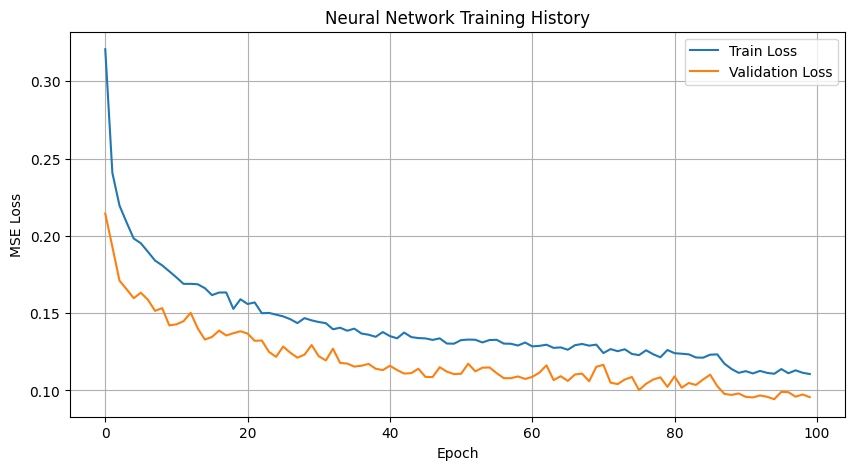


=== Neural Network Performance on Validation Set ===
Val MSE:  110.8776
Val RMSE: 10.5298 K
Val R^2:  0.9038

=== Model Comparison (Validation Set) ===
Neural Net   - RMSE: 10.5298 K, R²: 0.9038



In [3]:
# ============================================================
# 4. Simple Neural Network for Temperature Prediction
#    Using PyTorch for a feedforward neural network
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Load train.csv
data_path = "train.csv"
df = pd.read_csv(data_path)

# If the target column is not named 'critical_temp', adjust here:
if "critical_temp" in df.columns:
    target_col = "critical_temp"
else:
    # assume last column is the target
    target_col = df.columns[-1]
    print(f"WARNING: 'critical_temp' not found; using last column '{target_col}' as target.")

X = df.drop(columns=[target_col])
y = df[target_col]

print("=== Loaded train.csv for neural network ===")
print("X shape:", X.shape)
print("y shape:", y.shape)
print()

# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

print("=== Train/Validation Split ===")
print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print()

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print()

# Standardize features (important for neural networks)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

# Reshape y for scaler (needs 2D array)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

print("=== Data standardization complete ===")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_train_scaled mean (should be ~0): {X_train_scaled.mean():.6f}")
print(f"X_train_scaled std (should be ~1): {X_train_scaled.std():.6f}")
print()

# Create PyTorch Dataset
class SuperconductorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SuperconductorDataset(X_train_scaled, y_train_scaled)
val_dataset = SuperconductorDataset(X_val_scaled, y_val_scaled)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output layer (single value for temperature)
        layers.append(nn.Linear(prev_size, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x).squeeze()

# Initialize model
input_size = X_train_scaled.shape[1]
model = SimpleNN(input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.2).to(device)

print("=== Neural Network Architecture ===")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20
patience_counter = 0

print("=== Training Neural Network ===")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_nn_model.pth')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('best_nn_model.pth'))

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural Network Training History')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate on validation set (in original scale)
model.eval()
with torch.no_grad():
    X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
    y_val_pred_scaled = model(X_val_tensor).cpu().numpy()

# Inverse transform predictions
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
mse_nn = mean_squared_error(y_val, y_val_pred)
rmse_nn = mse_nn ** 0.5
r2_nn = r2_score(y_val, y_val_pred)

print("\n=== Neural Network Performance on Validation Set ===")
print(f"Val MSE:  {mse_nn:.4f}")
print(f"Val RMSE: {rmse_nn:.4f} K")
print(f"Val R^2:  {r2_nn:.4f}")
print()

# Compare with previous models (if they exist)
try:
    print("=== Model Comparison (Validation Set) ===")
    if 'rmse_rf' in globals() and 'r2_rf' in globals():
        print(f"Random Forest - RMSE: {rmse_rf:.4f} K, R²: {r2_rf:.4f}")
    if 'rmse_xgb' in globals() and 'r2_xgb' in globals():
        print(f"XGBoost      - RMSE: {rmse_xgb:.4f} K, R²: {r2_xgb:.4f}")
    print(f"Neural Net   - RMSE: {rmse_nn:.4f} K, R²: {r2_nn:.4f}")
    print()
except:
    print("=== Neural Network Results ===")
    print(f"RMSE: {rmse_nn:.4f} K")
    print(f"R²: {r2_nn:.4f}")
    print()
